#Explainability of Data Driven Models for Digital Twin for Battery Management Systems

## This notebook details the experimentation for evaluating XAI application to explainability of predictions of AI models which will serve as digital twins for BMS

###Prepared by: Judith Nkechinyere Njoku (December 2023)

In [ ]:
#import neccessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import SGD
from tensorflow.keras.layers import Dropout
from matplotlib import pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [ ]:
#Load data from drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Set a random seed
np.random.seed(42)

In [ ]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/")
!ls

 02_end_to_end_machine_learning_project.ipynb
'06_Binary Classification.ipynb'
 09.0_clustering_todo.ipynb
'16pskJudith_Wireless (1).ipynb'
 16pskJudith_Wireless.ipynb
'16PSK_REGAE_2021_(2,4).ipynb'
 18_reinforcement_learning.ipynb
 AE-norm.ipynb
'AE plot.ipynb'
 AI_Dataset_sim.ipynb
 AI_service_drive
 AI_Service_Drive.ipynb
'Anomaly gesture_BiLSTM.ipynb'
 Assignment_3_PR.ipynb
 AssignmentML4.ipynb
 assignt3.ipynb
 AUDIO_MLP.ipynb
' Audio_video_MLT_8classes.ipynb'
 Audio_video_MLT.ipynb
 autoencoder2by4-nodropnoregadam.ipynb
 autoencoder2by4-withdropandregu.ipynb
 autoencoder_7_4_symbol-Copy1.ipynb
 autoencoder_7_4_symbol-regularizeddropchoose.ipynb
 autoencoder_dynamic2by2-Copy1.ipynb
 autoencoder_for_MIMO_with_gaussian.ipynb
 autoencoder_NOREG2BY4NO2.ipynb
 autoencoder_with_gaussian_eugenio.ipynb
 autoencoder_with_reiligh_1_2.ipynb
 B0005_lstm_model.h5
 B0006_lstm_model.h5
 bat_data
 Battery_DT.ipynb
 Battery-Kalman.ipynb
 Battery_LLM
 Binary_assignment.ipynb
 Blockchain_Vehicle.ipyn

In [ ]:
data = pd.read_csv('discharge.csv')

In [ ]:
data.head()

Voltage_measured  Current_measured  Temperature_measured  Current_charge  \
0          3.974871         -2.012528             24.389085          1.9982   
1          3.951717         -2.013979             24.544752          1.9982   
2          3.934352         -2.011144             24.731385          1.9982   
3          3.920058         -2.013007             24.909816          1.9982   
4          3.907904         -2.014400             25.105884          1.9982   

   Voltage_charge     Time  Capacity  id_cycle       type  \
0           3.062   35.703  1.856487         1  discharge   
1           3.030   53.781  1.856487         1  discharge   
2           3.011   71.922  1.856487         1  discharge   
3           2.991   90.094  1.856487         1  discharge   
4           2.977  108.281  1.856487         1  discharge   

   ambient_temperature    time Battery  
0                   24  2008.0   B0005  
1                   24  2008.0   B0005  
2                   24  2008.0   B0005  
3                   24  2008.0   B0005  
4                   24  2008.0   B0005

In [ ]:
data.tail()

Voltage_measured  Current_measured  Temperature_measured  \
169761          2.835283         -2.011160             37.396003   
169762          2.774711         -2.011370             37.544067   
169763          2.690974         -2.010542             37.723665   
169764          2.566085         -2.011117             37.925675   
169765          2.365585         -2.011110             38.143742   

        Current_charge  Voltage_charge      Time  Capacity  id_cycle  \
169761          1.9986           1.937  2392.437  1.341051       132   
169762          1.9986           1.880  2406.250  1.341051       132   
169763          1.9986           1.806  2420.062  1.341051       132   
169764          1.9986           1.698  2433.890  1.341051       132   
169765          1.9986           1.524  2447.687  1.341051       132   

             type  ambient_temperature    time Battery  
169761  discharge                   24  2008.0   B0018  
169762  discharge                   24  2008.0   B0018  
169763  discharge                   24  2008.0   B0018  
169764  discharge                   24  2008.0   B0018  
169765  discharge                   24  2008.0   B0018

In [ ]:
# Feature Engineering for SoC and SoH estimation
# Discharge Time
data['Discharge_Time'] = data.groupby('id_cycle')['Time'].transform(max)

# Average Discharge Current
data['Average_Discharge_Current'] = data.groupby('id_cycle')['Current_measured'].transform('mean')

# For SoH
# Capacity Fade: Change in capacity over cycles
data['Capacity_Fade'] = data.groupby('Battery')['Capacity'].transform(lambda x: x.max() - x)

# Resistance Increase:This is inferred from voltage drop and current
# Assuming internal resistance increase correlates with decrease in capacity
data['Resistance_Increase'] = data['Capacity_Fade'] / data['Capacity'].max()

# Temperature Variations
data['Temperature_Variation'] = data.groupby('Battery')['Temperature_measured'].transform('std')

In [ ]:
# Estimating State of Charge (SoC) and State of Health (SoH)
# Assuming a simplified linear relationship between voltage and SoC

max_voltage = data['Voltage_measured'].max()
min_voltage = data['Voltage_measured'].min()

data['Estimated_SoC'] = ((data['Voltage_measured'] - min_voltage) / (max_voltage - min_voltage)) * 100

# Estimating SoH
# Assuming initial capacity is the maximum capacity observed
initial_capacity = data['Capacity'].max()
data['Estimated_SoH'] = (data['Capacity'] / initial_capacity) * 100

In [ ]:
data.head()

Voltage_measured  Current_measured  Temperature_measured  Current_charge  \
0          3.974871         -2.012528             24.389085          1.9982   
1          3.951717         -2.013979             24.544752          1.9982   
2          3.934352         -2.011144             24.731385          1.9982   
3          3.920058         -2.013007             24.909816          1.9982   
4          3.907904         -2.014400             25.105884          1.9982   

   Voltage_charge     Time  Capacity  id_cycle       type  \
0           3.062   35.703  1.856487         1  discharge   
1           3.030   53.781  1.856487         1  discharge   
2           3.011   71.922  1.856487         1  discharge   
3           2.991   90.094  1.856487         1  discharge   
4           2.977  108.281  1.856487         1  discharge   

   ambient_temperature    time Battery  Discharge_Time  \
0                   24  2008.0   B0005        3690.234   
1                   24  2008.0   B0005        3690.234   
2                   24  2008.0   B0005        3690.234   
3                   24  2008.0   B0005        3690.234   
4                   24  2008.0   B0005        3690.234   

   Average_Discharge_Current  Capacity_Fade  Resistance_Increase  \
0                  -2.006336            0.0                  0.0   
1                  -2.006336            0.0                  0.0   
2                  -2.006336            0.0                  0.0   
3                  -2.006336            0.0                  0.0   
4                  -2.006336            0.0                  0.0   

   Temperature_Variation  Estimated_SoC  Estimated_SoH  
0               3.723419      97.382329      91.212752  
1               3.723419      96.374746      91.212752  
2               3.723419      95.619121      91.212752  
3               3.723419      94.997098      91.212752  
4               3.723419      94.468162      91.212752

In [ ]:
df = pd.DataFrame(data)
num_unique_battery_types = df['Battery'].nunique()
print(f"Number of unique battery types: {num_unique_battery_types}")

Number of unique battery types: 4


In [ ]:
df = df[df['Battery'].isin(['B0005','B0007','B0018','B0006'])]
df = df[df['Temperature_measured'] > 36] #choose battery B0005
#df['Time'] =pd.to_datetime(df['Time'], unit='s')
dfb = df.groupby(['id_cycle']).max()
dfb['Cumulated_T'] = dfb['Time'].cumsum()
df.head()

Voltage_measured  Current_measured  Temperature_measured  Current_charge  \
154          3.382031         -2.012391             36.068027          1.9982   
155          3.376548         -2.011771             36.151799          1.9982   
156          3.370452         -2.013057             36.226208          1.9982   
157          3.363787         -2.013130             36.317584          1.9982   
158          3.356852         -2.010505             36.401753          1.9982   

     Voltage_charge      Time  Capacity  id_cycle       type  \
154           2.466  2897.937  1.856487         1  discharge   
155           2.460  2917.281  1.856487         1  discharge   
156           2.454  2936.687  1.856487         1  discharge   
157           2.448  2956.078  1.856487         1  discharge   
158           2.442  2975.453  1.856487         1  discharge   

     ambient_temperature    time Battery  Discharge_Time  \
154                   24  2008.0   B0005        3690.234   
155                   24  2008.0   B0005        3690.234   
156                   24  2008.0   B0005        3690.234   
157                   24  2008.0   B0005        3690.234   
158                   24  2008.0   B0005        3690.234   

     Average_Discharge_Current  Capacity_Fade  Resistance_Increase  \
154                  -2.006336            0.0                  0.0   
155                  -2.006336            0.0                  0.0   
156                  -2.006336            0.0                  0.0   
157                  -2.006336            0.0                  0.0   
158                  -2.006336            0.0                  0.0   

     Temperature_Variation  Estimated_SoC  Estimated_SoH  
154               3.723419      71.584186      91.212752  
155               3.723419      71.345594      91.212752  
156               3.723419      71.080301      91.212752  
157               3.723419      70.790281      91.212752  
158               3.723419      70.488503      91.212752

<ipython-input-13-a09fe43bf94d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='Temperature_measured', y='Battery', inner='box', palette='Dark2')


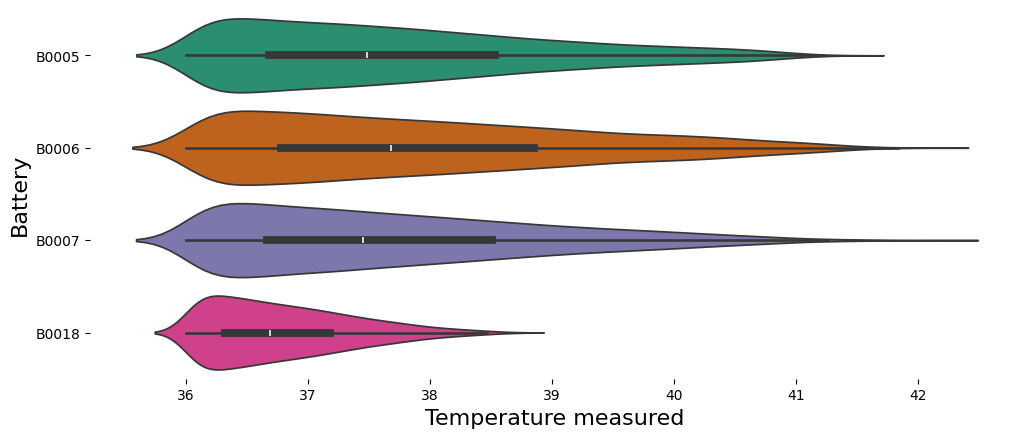

In [ ]:
# @title Battery vs Temperature_measured
figsize = (12, 1.2 * len(df['Battery'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Temperature_measured', y='Battery', inner='box', palette='Dark2')
# Set the axis labels
plt.xlabel('Temperature measured', fontsize=16)
plt.ylabel('Battery', fontsize=16)
sns.despine(top=True, right=True, bottom=True, left=True)

<ipython-input-14-275832b4b2d6>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='Current_measured', y='Battery', inner='box', palette='Dark2')


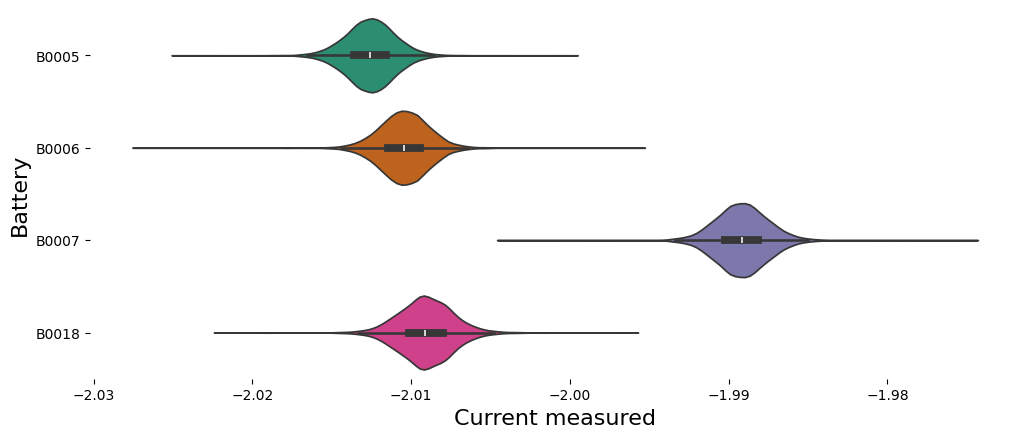

In [ ]:
# @title Battery vs Current_measured
figsize = (12, 1.2 * len(df['Battery'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Current_measured', y='Battery', inner='box', palette='Dark2')
# Set the axis labels
plt.xlabel('Current measured', fontsize=16)
plt.ylabel('Battery', fontsize=16)
sns.despine(top=True, right=True, bottom=True, left=True)

<ipython-input-15-bddf80f05fb8>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='Voltage_measured', y='Battery', inner='box', palette='Dark2')


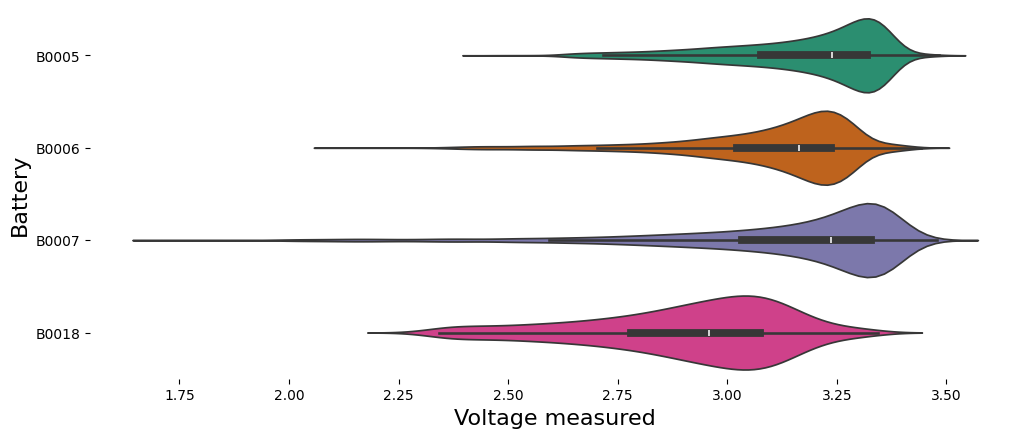

In [ ]:
# @title Battery vs Voltage_measured
figsize = (12, 1.2 * len(df['Battery'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Voltage_measured', y='Battery', inner='box', palette='Dark2')
# Set the axis labels
plt.xlabel('Voltage measured', fontsize=16)
plt.ylabel('Battery', fontsize=16)
sns.despine(top=True, right=True, bottom=True, left=True)

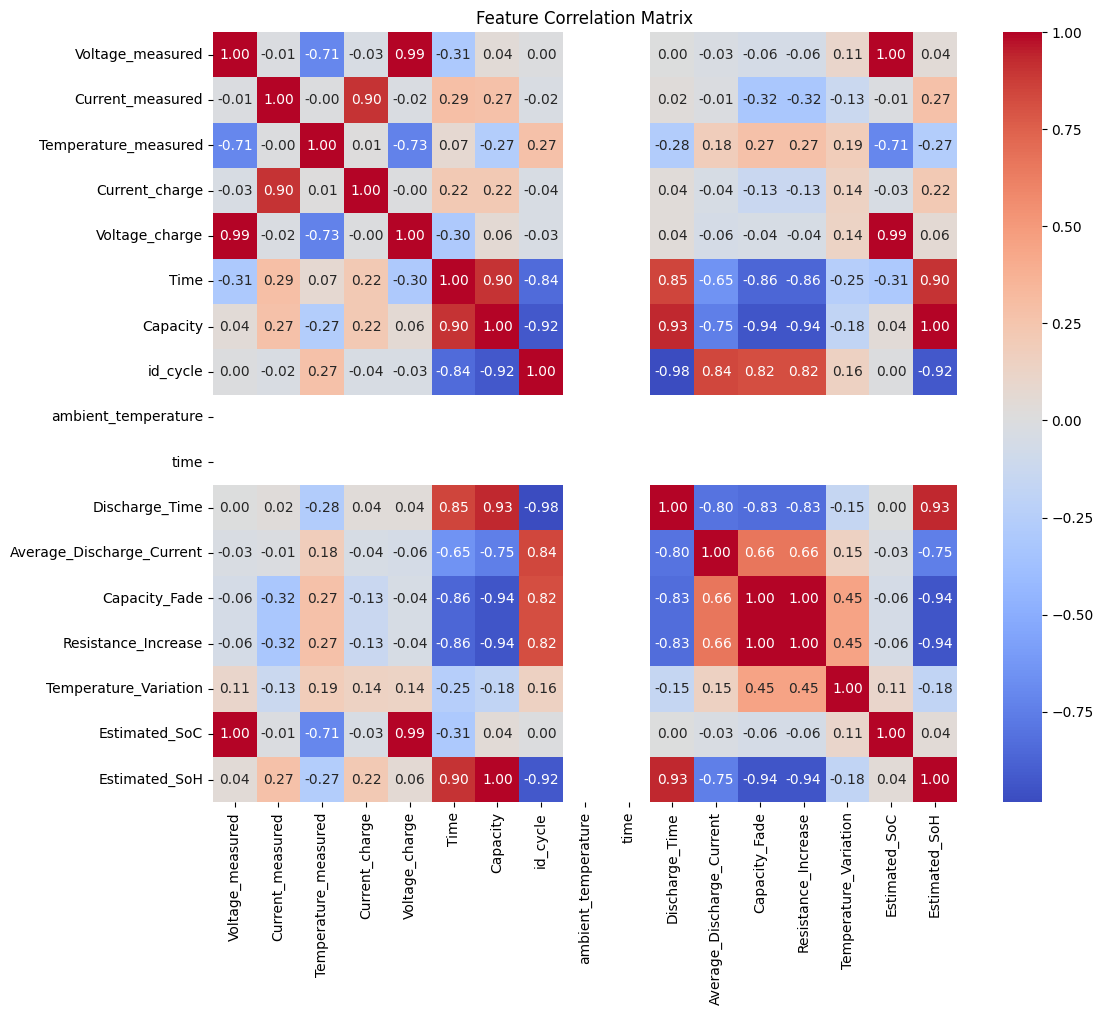

In [ ]:
# Identify the column containing non-numeric data
non_numeric_column = ['type', 'Battery']

# Drop rows containing non-numeric data
df = df.drop(non_numeric_column, axis=1)
# Calculating the correlation matrix
correlation_matrix = df.corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

In [ ]:
# Calculating the correlation of all features with Estimated_SoC and Estimated_SoH
correlation_with_soc = df.corr()['Estimated_SoC'].sort_values(ascending=False)
correlation_with_soh = df.corr()['Estimated_SoH'].sort_values(ascending=False)

# Display the correlations
print("Correlation with Estimated SoC:")
print(correlation_with_soc)
print("\nCorrelation with Estimated SoH:")
print(correlation_with_soh)

Correlation with Estimated SoC:
Estimated_SoC                1.000000
Voltage_measured             1.000000
Voltage_charge               0.993941
Temperature_Variation        0.105339
Capacity                     0.044443
Estimated_SoH                0.044443
Discharge_Time               0.001084
id_cycle                     0.000452
Current_measured            -0.011289
Average_Discharge_Current   -0.028028
Current_charge              -0.032445
Capacity_Fade               -0.057324
Resistance_Increase         -0.057324
Time                        -0.307237
Temperature_measured        -0.705587
ambient_temperature               NaN
time                              NaN
Name: Estimated_SoC, dtype: float64

Correlation with Estimated SoH:
Capacity                     1.000000
Estimated_SoH                1.000000
Discharge_Time               0.933523
Time                         0.903790
Current_measured             0.274535
Current_charge               0.219814
Voltage_charge           

In [ ]:
# Filtering correlations above 0.50 or below -0.50
high_correlation_with_soc = correlation_with_soc[(correlation_with_soc > 0.50) | (correlation_with_soc < -0.50)]
high_correlation_with_soh = correlation_with_soh[(correlation_with_soh > 0.50) | (correlation_with_soh < -0.50)]

# Display the high correlations
print("High Correlation with Estimated SoC:")
print(high_correlation_with_soc)
print("\nHigh Correlation with Estimated SoH:")
print(high_correlation_with_soh)

High Correlation with Estimated SoC:
Estimated_SoC           1.000000
Voltage_measured        1.000000
Voltage_charge          0.993941
Temperature_measured   -0.705587
Name: Estimated_SoC, dtype: float64

High Correlation with Estimated SoH:
Capacity                     1.000000
Estimated_SoH                1.000000
Discharge_Time               0.933523
Time                         0.903790
Average_Discharge_Current   -0.745430
id_cycle                    -0.924501
Resistance_Increase         -0.936377
Capacity_Fade               -0.936377
Name: Estimated_SoH, dtype: float64


#SOC Estimation

In [ ]:
# Creating a subset of the data with only the highly correlated features
high_corr_features_soc = high_correlation_with_soc.index.tolist()
subset_data_soc = df[high_corr_features_soc]

In [ ]:
# Display the first few rows of the subset
print(subset_data_soc.head())

     Estimated_SoC  Voltage_measured  Voltage_charge  Temperature_measured
154      71.584186          3.382031           2.466             36.068027
155      71.345594          3.376548           2.460             36.151799
156      71.080301          3.370452           2.454             36.226208
157      70.790281          3.363787           2.448             36.317584
158      70.488503          3.356852           2.442             36.401753


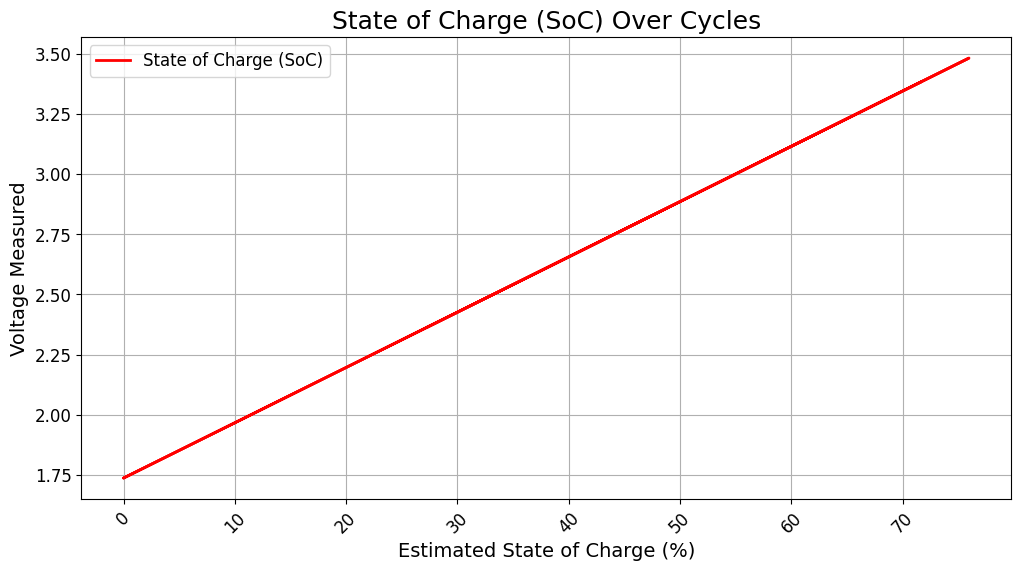

In [ ]:
# Plot SoC
plt.figure(figsize=(12, 6))
plt.plot(subset_data_soc['Estimated_SoC'], subset_data_soc['Voltage_measured'], label='State of Charge (SoC)', color='red', linewidth=2)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Estimated State of Charge (%)',  fontsize=14)
plt.ylabel('Voltage Measured', fontsize=14)
plt.title('State of Charge (SoC) Over Cycles', fontsize=18)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

### The following models will be used for SoC estimation:
* DNN
* LSTM



In [ ]:
#Prepare inputs and outputs
X = subset_data_soc.drop('Estimated_SoC', axis=1)  # Input features
y = subset_data_soc['Estimated_SoC']  # Output feature (SoH)

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

##Apply DNN for SoC prediciton

In [ ]:
#Construct DNN Model
modeldnn = Sequential()
modeldnn.add(Dense(64, activation='relu'))
modeldnn.add(Dense(64, activation='relu'))
modeldnn.add(Dense(1))

In [ ]:
# Compile the model
modeldnn.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
# Train the model
historydnn = modeldnn.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100
611/611 [==============================] - 6s 4ms/step - loss: 278.2325 - mae: 11.5778 - val_loss: 121.5252 - val_mae: 8.4399
Epoch 2/100
611/611 [==============================] - 2s 3ms/step - loss: 113.8136 - mae: 8.2789 - val_loss: 102.3786 - val_mae: 7.7753
Epoch 3/100
611/611 [==============================] - 2s 3ms/step - loss: 83.0906 - mae: 6.9936 - val_loss: 46.1927 - val_mae: 4.8488
Epoch 4/100
611/611 [==============================] - 2s 3ms/step - loss: 10.2532 - mae: 2.0236 - val_loss: 1.9419 - val_mae: 1.0046
Epoch 5/100
611/611 [==============================] - 2s 3ms/step - loss: 2.0160 - mae: 1.0696 - val_loss: 2.2635 - val_mae: 1.0732
Epoch 6/100
611/611 [==============================] - 3s 5ms/step - loss: 1.9941 - mae: 1.0669 - val_loss: 2.2400 - val_mae: 1.0560
Epoch 7/100
611/611 [==============================] - 4s 6ms/step - loss: 1.9901 - mae: 1.0681 - val_loss: 1.7898 - val_mae: 0.9769
Epoch 8/100
611/611 [==============================] - 3s

In [ ]:
# Print the model summary
modeldnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                256       
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4481 (17.50 KB)
Trainable params: 4481 (17.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


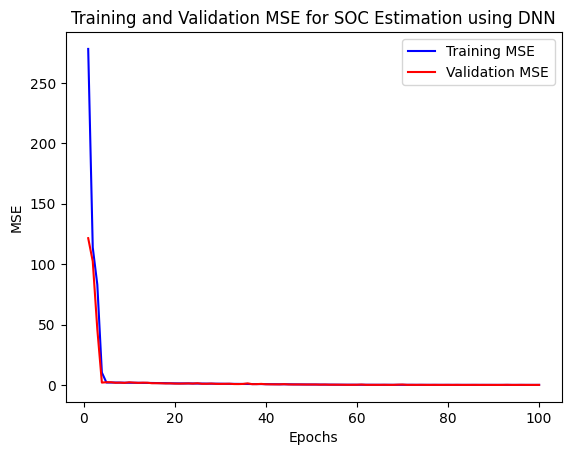

In [ ]:
# Extracting MSE from the history object
mse_dnn = historydnn.history['loss']
val_mse_dnn = historydnn.history['val_loss']

# Creating the plot
epochs = range(1, len(mse_dnn) + 1)
plt.plot(epochs, mse_dnn, 'b-', label='Training MSE')
plt.plot(epochs, val_mse_dnn, 'r-', label='Validation MSE')
plt.title('Training and Validation MSE for SOC Estimation using DNN')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

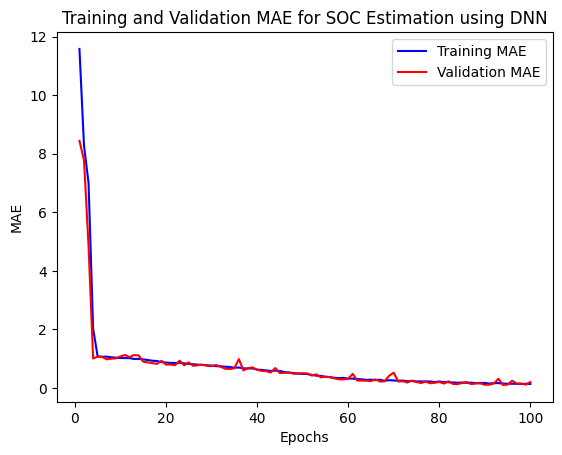

In [ ]:
# Extracting MSE from the history object
mae_dnn = historydnn.history['mae']
val_mae_dnn = historydnn.history['val_mae']

# Creating the plot
epochs = range(1, len(mae_dnn) + 1)
plt.plot(epochs, mae_dnn, 'b-', label='Training MAE')
plt.plot(epochs, val_mae_dnn, 'r-', label='Validation MAE')
plt.title('Training and Validation MAE for SOC Estimation using DNN')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

In [ ]:
#test the model
y_pred = modeldnn.predict(X_test)

68/68 [==============================] - 0s 2ms/step


In [ ]:
# Compute Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 0.047774926504417545
Mean Absolute Error (MAE): 0.20163718106557885


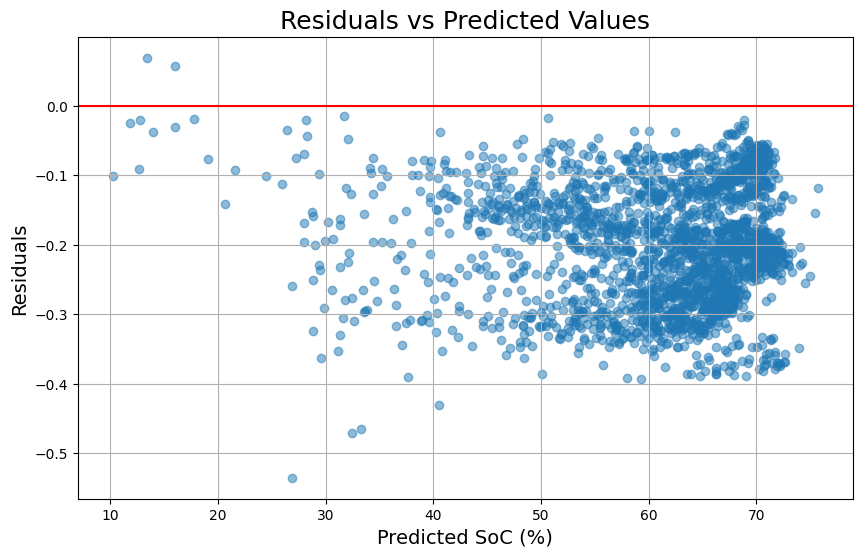

In [ ]:
residuals = y_test - y_pred.flatten()
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.title('Residuals vs Predicted Values', fontsize=18)
plt.xlabel('Predicted SoC (%)', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.axhline(y=0, color='r', linestyle='-')
plt.grid(True)
plt.show()

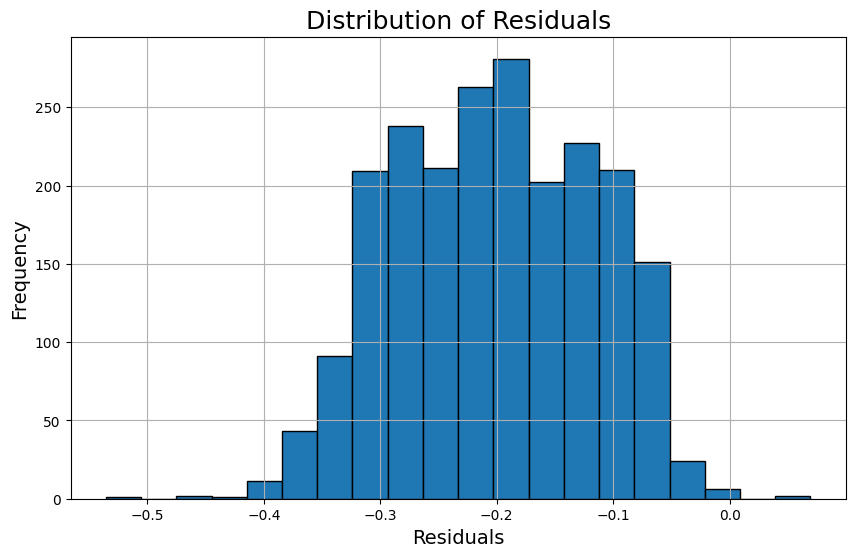

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, edgecolor='black')
plt.title('Distribution of Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()

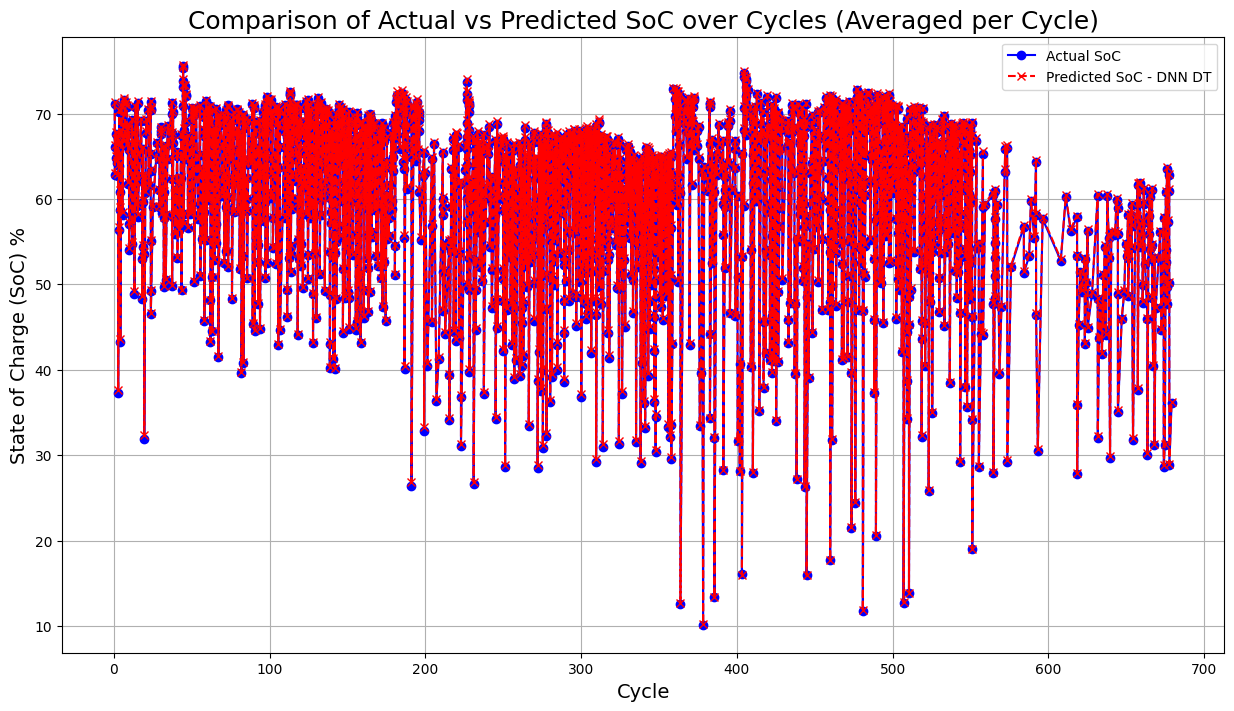

In [ ]:
# Group by cycle and calculate the mean
y_pred= y_pred.flatten()
grouped_test = y_test.groupby(y_test.index).mean()
grouped_pred = pd.Series(y_pred, index=y_test.index).groupby(y_test.index).mean()

# Plot the averaged values
plt.figure(figsize=(15, 8))
plt.plot(grouped_test.index/250, grouped_test, label='Actual SoC ', color='blue', marker='o')
plt.plot(grouped_pred.index/250, grouped_pred, label='Predicted SoC - DNN DT', color='red', linestyle='dashed', marker='x')
plt.xlabel('Cycle', fontsize=14)
plt.ylabel('State of Charge (SoC) %', fontsize=14)
plt.title('Comparison of Actual vs Predicted SoC over Cycles (Averaged per Cycle)', fontsize=18)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Now lets conduct explainability for this model
#We will apply three different methods:
#1. feature-importance model, 2. surrograte models, 3. rule-based explanations.

In [ ]:
!pip install shap

In [ ]:
import shap
# Select a smaller random sample from X_train for the background dataset
background = shap.sample(X_train, 100)  # Adjust the sample size as needed

# Create a SHAP explainer object
explainer = shap.KernelExplainer(modeldnn.predict, background)

4/4 [==============================] - 0s 11ms/step


In [ ]:
# Compute SHAP values
shap_values = explainer.shap_values(shap.sample(X_test, 100))

  0%|          | 0/100 [00:00<?, ?it/s]

19/19 [==============================] - 0s 2ms/step


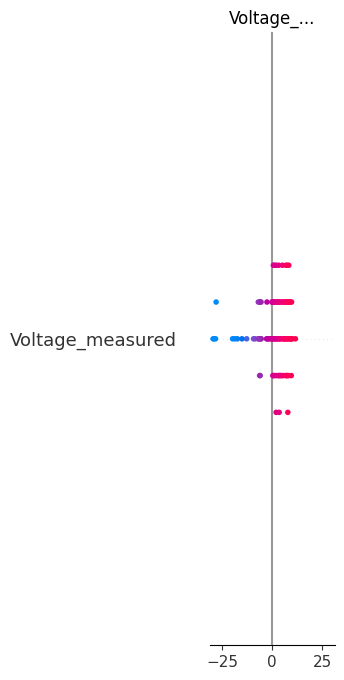

In [ ]:
# Visualize the results
shap.summary_plot(shap_values, shap.sample(X_test, 100), plot_type='bar')

In [ ]:
shap.plots.waterfall(shap_values[0], max_display=14)

TypeError: The waterfall plot requires an `Explanation` object as the `shap_values` argument.

In [ ]:
shap.dependence_plot(2, shap_values, shap.sample(X_test, 100))

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1 and the array at index 1 has size 10

In [ ]:
i = 18
shap.force_plot(explainer.expected_value, shap_values[i], shap.sample(X_test, 100))

IndexError: index 1 is out of bounds for axis 0 with size 1

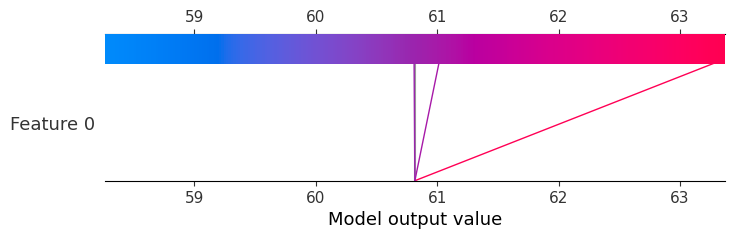

In [ ]:
shap.decision_plot(explainer.expected_value[0], shap_values[0])

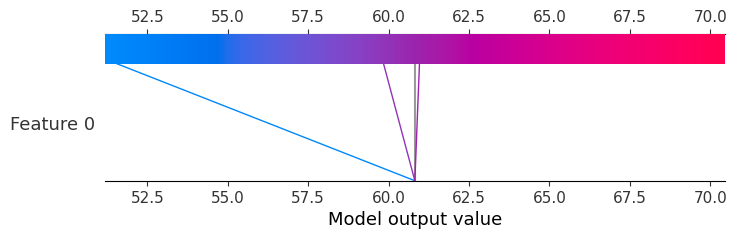

In [ ]:
shap.decision_plot(explainer.expected_value[0], shap_values[1])

In [ ]:
# Compute the mean absolute SHAP value for each feature
mean_abs_shap_values = np.mean(np.abs(shap_values[0]), axis=0)

# Calculate the overall decision impact ratio as the average of these mean values
overall_decision_impact_ratio = np.mean(mean_abs_shap_values)
print("Overall Decision Impact Ratio:", overall_decision_impact_ratio)

Overall Decision Impact Ratio: 0.8861762237548939


In [ ]:
#Compute confidence score
predicted_probabilities = modeldnn.predict(X_test)

# Calculate the maximum probability for each prediction (i.e., confidence)
confidence_scores = np.max(predicted_probabilities, axis=1)

# Calculate the average confidence score
average_confidence_score = np.mean(confidence_scores)
print("Average Confidence Score:", average_confidence_score)

68/68 [==============================] - 0s 1ms/step
Average Confidence Score: 60.619606


In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=a21e2da5f329c1672a55ce7eb7abcfa018cc242da36ae50faa7ef025f6ef8ae3
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import lime
import lime.lime_tabular

In [ ]:
# Assuming X_train is your training dataset and it's a DataFrame
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns.tolist(),
    class_names=['output'],
    mode='regression'
)

In [ ]:
# Selecting the first instance from the test set as an example
instance = X_test.iloc[0]

In [ ]:
# Define a prediction function that takes a 2D numpy array
def predict_fn(x):
    return modeldnn.predict(x).flatten()

# Generate the LIME explanation
exp = explainer.explain_instance(
    data_row=instance.values,
    predict_fn=predict_fn
)

157/157 [==============================] - 0s 2ms/step


In [ ]:
# Show the explanation in a Jupyter Notebook
exp.show_in_notebook(show_table=True, show_all=False)


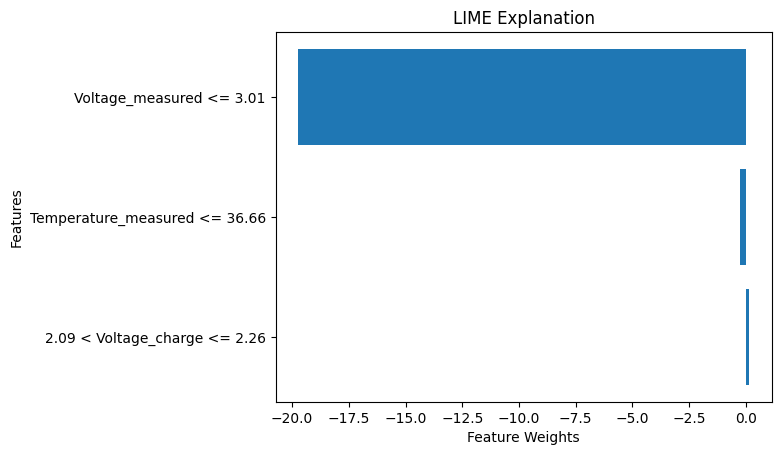

In [ ]:
# Get the feature names and their corresponding weights
feature_names, feature_weights = zip(*exp.as_list())

# Create a bar plot
plt.barh(feature_names, feature_weights)
plt.xlabel('Feature Weights')
plt.ylabel('Features')
plt.title('LIME Explanation')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

In [ ]:
# Define a prediction function for the DNN model
def dnn_predict_fn(x):
    return modeldnn.predict(x)
# Create the LIME explainer for the DNN model
dnn_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns.tolist(),
    class_names=['output'],
    mode='regression'
)
# Select the same instance from X_test to explain
dnn_instance = X_test.iloc[0].values

# Generate the LIME explanation for the DNN model
dnn_exp = dnn_explainer.explain_instance(
    data_row=dnn_instance,  # No need to reshape for the DNN
    predict_fn=dnn_predict_fn
)

# The R-squared value of the explanation can serve as a proxy for the confidence score
dnn_lime_r_squared = dnn_exp.score
print("DNN LIME R-squared:", dnn_lime_r_squared)


157/157 [==============================] - 0s 1ms/step
DNN LIME R-squared: 0.770304244852581


In [ ]:
# Getting feature weights from LIME explanation
feature_weights = np.array([weight for feature, weight in exp.as_list()])

# Decision Impact Ratio could be the sum of absolute weights
# It represents the overall impact of the features on the decision
decision_impact_ratio = np.sum(np.abs(feature_weights))
print("Decision Impact Ratio:", decision_impact_ratio)

Decision Impact Ratio: 20.130496468976045


In [ ]:
#Surrogate Model for XAI
dnn_predictions_train = modeldnn.predict(X_train)
dnn_predictions_test = modeldnn.predict(X_test)

68/68 [==============================] - 0s 2ms/step


In [ ]:
#Train linear regression model as a surrogate
from sklearn.linear_model import LinearRegression

# Create a linear regression model
surrogate_model = LinearRegression()
# Train the surrogate model
surrogate_model.fit(X_train, dnn_predictions_train)

LinearRegression()

In [ ]:
#Interprete the surrograte model
# Get feature names and coefficients
feature_names = X_train.columns
coefficients = surrogate_model.coef_

# Display the coefficients for interpretation
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef}")

Voltage_measured: [40.22027147  3.76685149  0.05005932]


In [ ]:
#Evaluate the surrogate model
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions with the surrogate model on the test set
surrogate_predictions = surrogate_model.predict(X_test)

# Evaluate the surrogate model
mse = mean_squared_error(dnn_predictions_test, surrogate_predictions)
r2 = r2_score(dnn_predictions_test, surrogate_predictions)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}") #This represents the confidence score

Mean Squared Error: 1.4737924033296096e-06
R-squared: 0.9999999851563975


In [ ]:
# Reshape coefficients if necessary
coefficients = np.array(coefficients).flatten()

In [ ]:
# Check the shapes
print("Coefficients shape:", coefficients.shape)
print("Feature names shape:", len(feature_names))

Coefficients shape: (3,)
Feature names shape: 3


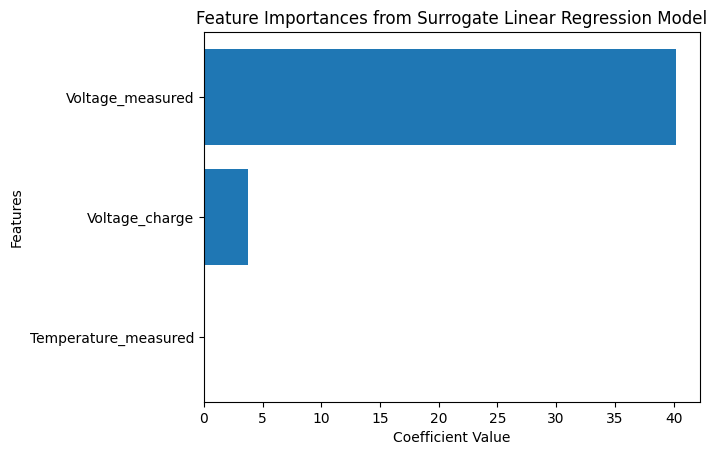

In [ ]:
plt.barh(feature_names, coefficients)
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Importances from Surrogate Linear Regression Model')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
#Prediction residuals. smaller residuals imply higher confidence
residuals = dnn_predictions_test - surrogate_predictions
mean_residual = np.mean(np.abs(residuals))
print("Mean Residual:", mean_residual)

Mean Residual: 0.0002389129627898302


In [ ]:
decision_impact_ratio = np.sum(np.abs(coefficients))
print("Decision Impact Ratio:", decision_impact_ratio)

Decision Impact Ratio: 44.037182275644554


## LSTM Model

In [ ]:
# Define the number of time steps
num_time_steps = 3  # Adjust this based on your specific dataset

# Assuming X is a DataFrame and already scaled
X_train_reshaped = X_train.values.reshape((-1, num_time_steps, 1))
X_val_reshaped = X_val.values.reshape((-1, num_time_steps, 1))
X_test_reshaped = X_test.values.reshape((-1, num_time_steps, 1))

In [ ]:
# Construct the RNN model
model_rnn = Sequential()
model_rnn.add(LSTM(64, activation='relu', input_shape=(num_time_steps, 1)))
model_rnn.add(Dense(64, activation='relu'))
model_rnn.add(Dense(1))

# Compile the model
model_rnn.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
# Train the model
history_rnn = model_rnn.fit(
    X_train_reshaped,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_reshaped, y_val)
)


Epoch 1/100
611/611 [==============================] - 10s 12ms/step - loss: 260.0229 - mae: 7.2922 - val_loss: 2.1616 - val_mae: 0.7165
Epoch 2/100
611/611 [==============================] - 10s 16ms/step - loss: 1.2802 - mae: 0.6251 - val_loss: 0.7705 - val_mae: 0.5469
Epoch 3/100
611/611 [==============================] - 9s 15ms/step - loss: 0.6663 - mae: 0.5556 - val_loss: 0.4910 - val_mae: 0.4730
Epoch 4/100
611/611 [==============================] - 10s 17ms/step - loss: 0.4924 - mae: 0.5057 - val_loss: 0.4934 - val_mae: 0.5161
Epoch 5/100
611/611 [==============================] - 9s 14ms/step - loss: 0.3576 - mae: 0.4385 - val_loss: 0.3073 - val_mae: 0.4186
Epoch 6/100
611/611 [==============================] - 5s 7ms/step - loss: 0.2785 - mae: 0.3925 - val_loss: 0.2705 - val_mae: 0.4029
Epoch 7/100
611/611 [==============================] - 6s 9ms/step - loss: 0.2394 - mae: 0.3701 - val_loss: 0.2778 - val_mae: 0.4239
Epoch 8/100
611/611 [==============================] - 4s 7

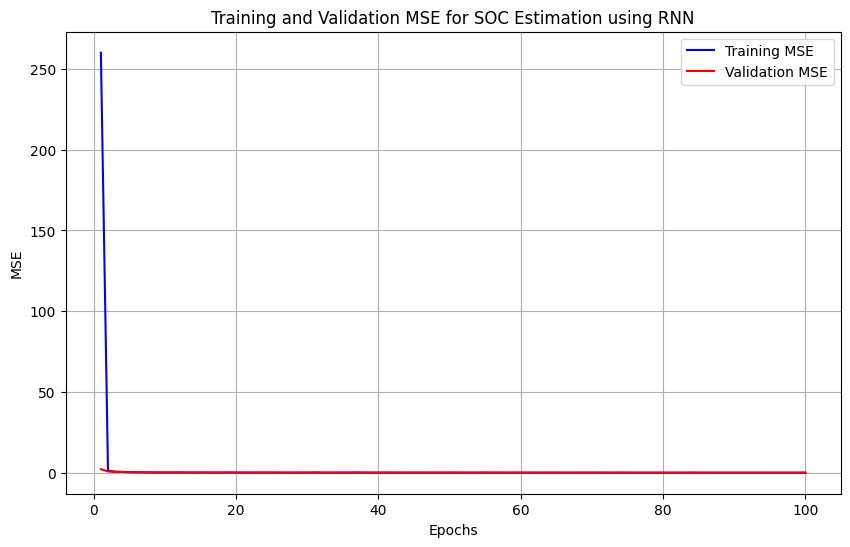

In [ ]:
# Extract the MSE from the history object of RNN model
mse_rnn = history_rnn.history['loss']
val_mse_rnn = history_rnn.history['val_loss']

#MSE plot
epochs = range(1, len(mse_rnn) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, mse_rnn, 'b-', label='Training MSE')
plt.plot(epochs, val_mse_rnn, 'r-', label='Validation MSE')
plt.title('Training and Validation MSE for SOC Estimation using RNN')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

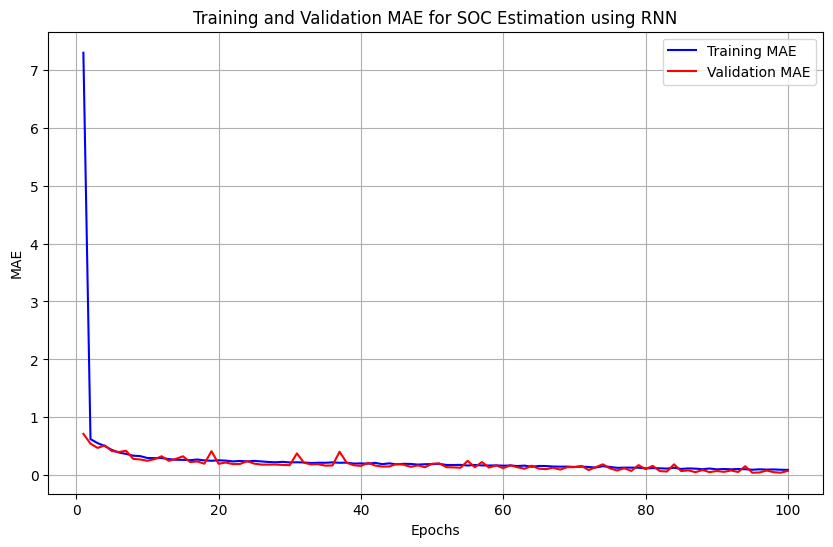

In [ ]:
# Extracting MAE from the history object of RNN model
mae_rnn = history_rnn.history['mae']
val_mae_rnn = history_rnn.history['val_mae']

# Creating the plot for MAE
epochs = range(1, len(mae_rnn) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, mae_rnn, 'b-', label='Training MAE')
plt.plot(epochs, val_mae_rnn, 'r-', label='Validation MAE')
plt.title('Training and Validation MAE for SOC Estimation using RNN')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Evaluate the model
y_pred_rnn = model_rnn.predict(X_test_reshaped)


68/68 [==============================] - 0s 2ms/step


In [ ]:
model_rnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 21121 (82.50 KB)
Trainable params: 21121 (82.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Ensure y_pred_rnn is flattened
y_pred_rnn = y_pred_rnn.flatten()

# Compute Mean Squared Error (MSE)
mse_rnn = mean_squared_error(y_test, y_pred_rnn)
print("Mean Squared Error (MSE):", mse_rnn)

# Compute Mean Absolute Error (MAE)
mae_rnn = mean_absolute_error(y_test, y_pred_rnn)
print("Mean Absolute Error (MAE):", mae_rnn)

Mean Squared Error (MSE): 0.0076543438883584355
Mean Absolute Error (MAE): 0.07793298151785294


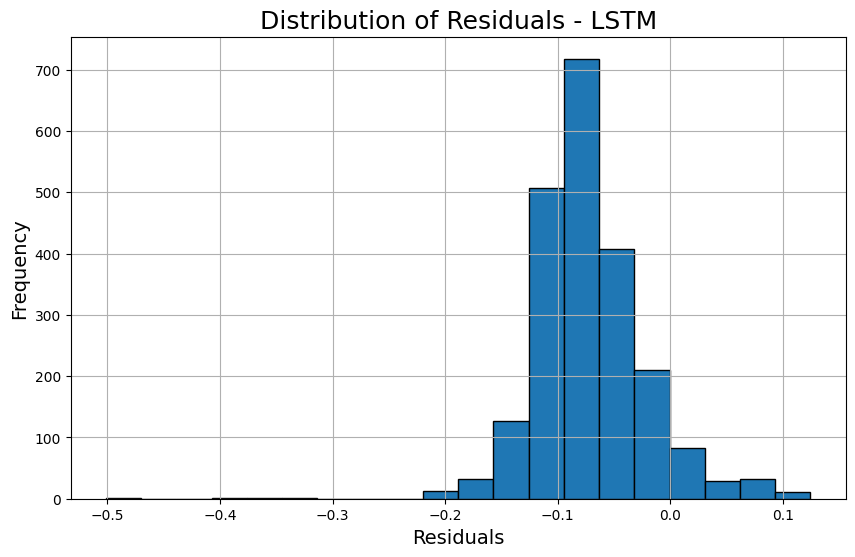

In [ ]:
# Calculate residuals
residuals_rnn = y_test - y_pred_rnn

# Plot histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals_rnn, bins=20, edgecolor='black')
plt.title('Distribution of Residuals - LSTM', fontsize=18)
plt.xlabel('Residuals', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()

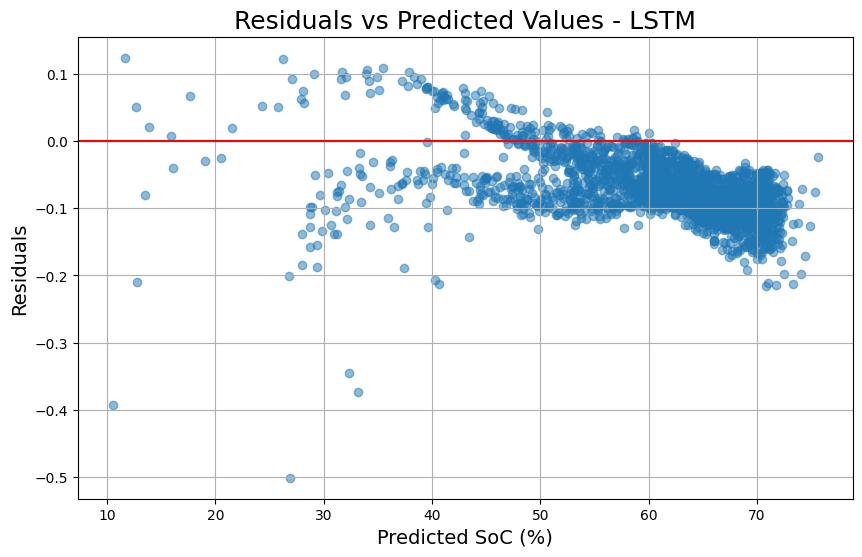

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_rnn, residuals_rnn, alpha=0.5)
plt.title('Residuals vs Predicted Values - LSTM', fontsize=18)
plt.xlabel('Predicted SoC (%)', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.axhline(y=0, color='r', linestyle='-')
plt.grid(True)
plt.show()

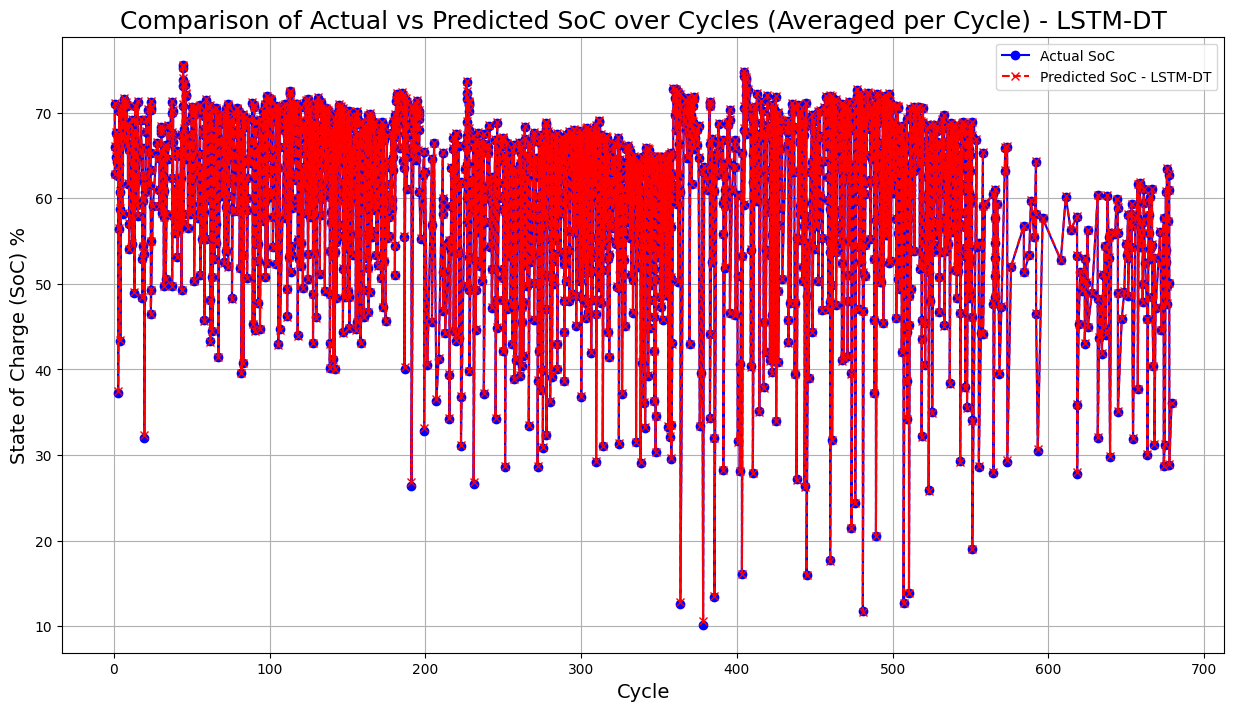

In [ ]:
# Group by cycle and calculate the mean
grouped_test_rnn = y_test.groupby(y_test.index).mean()
grouped_pred_rnn = pd.Series(y_pred_rnn, index=y_test.index).groupby(y_test.index).mean()

# Plot the averaged values
plt.figure(figsize=(15, 8))
plt.plot(grouped_test_rnn.index/250, grouped_test_rnn, label='Actual SoC ', color='blue', marker='o')
plt.plot(grouped_pred_rnn.index/250, grouped_pred_rnn, label='Predicted SoC - LSTM-DT', color='red', linestyle='dashed', marker='x')
plt.xlabel('Cycle', fontsize=14)
plt.ylabel('State of Charge (SoC) %', fontsize=14)
plt.title('Comparison of Actual vs Predicted SoC over Cycles (Averaged per Cycle) - LSTM-DT', fontsize=18)
plt.legend()
plt.grid(True)
plt.show()

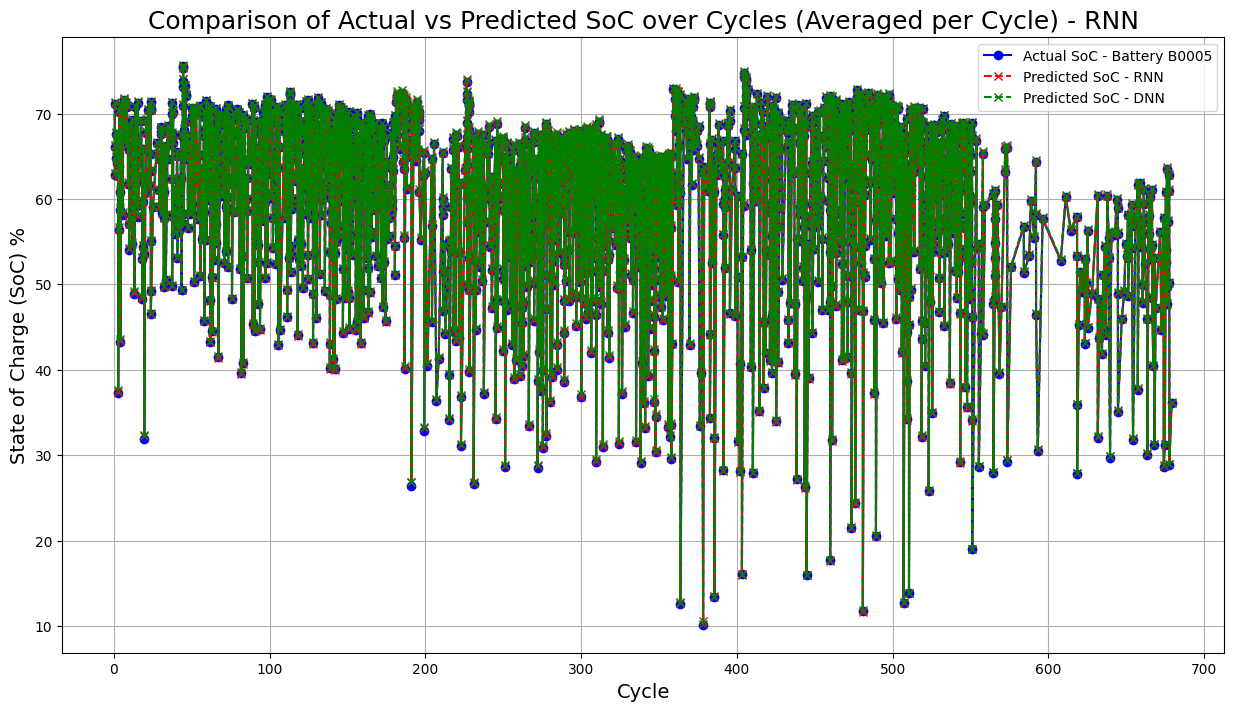

In [ ]:
# Group by cycle and calculate the mean

grouped_pred = pd.Series(y_pred, index=y_test.index).groupby(y_test.index).mean()
grouped_test_rnn = y_test.groupby(y_test.index).mean()
grouped_pred_rnn = pd.Series(y_pred_rnn, index=y_test.index).groupby(y_test.index).mean()

# Plot the averaged values
plt.figure(figsize=(15, 8))
plt.plot(grouped_test_rnn.index/250, grouped_test_rnn, label='Actual SoC - Battery B0005', color='blue', marker='o')
plt.plot(grouped_pred_rnn.index/250, grouped_pred_rnn, label='Predicted SoC - RNN', color='red', linestyle='dashed', marker='x')
plt.plot(grouped_pred_rnn.index/250, grouped_pred, label='Predicted SoC - DNN', color='green', linestyle='dashed', marker='x')
plt.xlabel('Cycle', fontsize=14)
plt.ylabel('State of Charge (SoC) %', fontsize=14)
plt.title('Comparison of Actual vs Predicted SoC over Cycles (Averaged per Cycle) - RNN', fontsize=18)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def lstm_predict_wrapper(X):
    # Reshape X to 3D for the LSTM model
    X_reshaped = X.reshape((-1, num_time_steps, 1))
    # Perform the prediction
    predictions = model_rnn.predict(X_reshaped)
    # Reshape predictions to 2D for SHAP
    return predictions.reshape(-1, 1)

In [ ]:
# Select a smaller random sample from X_train for the background dataset
background = shap.sample(X_train, 100).values  # Adjust the sample size as needed
# Reshape background data to 2D
background_reshaped = background.reshape((-1, num_time_steps))
# Assuming 'subset_data_soh' is your original DataFrame and it includes the feature names
original_feature_names = subset_data_soc.drop('Estimated_SoC', axis=1).columns.tolist()

In [ ]:
# Create a SHAP explainer object
explainer = shap.KernelExplainer(lstm_predict_wrapper, background_reshaped)

4/4 [==============================] - 0s 19ms/step


In [ ]:
# Sample from X_test and reshape for SHAP analysis
X_test_sample = shap.sample(X_test, 50).values  # Adjust the sample size as needed
X_test_sample_reshaped = X_test_sample.reshape((-1, num_time_steps))

# Compute SHAP values
shap_values = explainer.shap_values(X_test_sample_reshaped)

# Create feature names for each timestep
feature_names = [f"{feature}_Timestep{timestep+1}" for timestep in range(num_time_steps) for feature in original_feature_names]

  0%|          | 0/50 [00:00<?, ?it/s]

19/19 [==============================] - 0s 2ms/step


In [ ]:
feature_names = list(map(str, feature_names))

TypeError: only integer scalar arrays can be converted to a scalar index

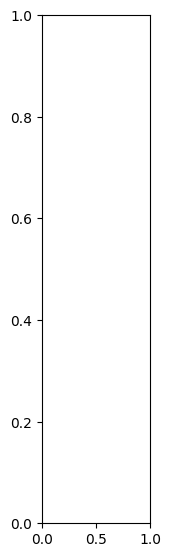

In [ ]:
# Visualize the results with actual feature names
shap.summary_plot(shap_values, X_test_sample_reshaped, feature_names=feature_names, plot_type='bar')

In [ ]:
# Assuming shap_values is a list of arrays (one for each class/output in a multi-output model)
# For regression models, it will typically have a single array
mean_abs_shap_values = np.mean(np.abs(shap_values[0]), axis=0)
overall_decision_impact_ratio = np.mean(mean_abs_shap_values)
print("Overall Decision Impact Ratio:", overall_decision_impact_ratio)

Overall Decision Impact Ratio: 0.881019172668457


In [ ]:
# Assuming the LSTM model is for regression and outputs a single value per prediction
predicted_values = model_rnn.predict(X_test)

# Use the magnitude of predicted values as a proxy for confidence scores
# (This method is a simplification and should be used cautiously)
confidence_scores = np.abs(predicted_values)

# Calculate the average confidence score
average_confidence_score = np.mean(confidence_scores)
print("Average Confidence Score:", average_confidence_score)

68/68 [==============================] - 0s 2ms/step
Average Confidence Score: 60.490402


In [ ]:
#Apply LIME
# Define a prediction function that reshapes input for the RNN and gets predictions
def rnn_predict_fn(x):
    x_reshaped = x.reshape((-1, num_time_steps, 1))  # Reshape to 3D for the RNN
    return model_rnn.predict(x_reshaped)

In [ ]:
# Create a list of new feature names that reflect the time steps
expanded_feature_names = [f"{feature}_Timestep{timestep+1}" for timestep in range(num_time_steps) for feature in original_feature_names]

# Create the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_reshaped.reshape(X_train_reshaped.shape[0], -1),
    feature_names=expanded_feature_names,
    class_names=['output'],
    mode='regression'
)

In [ ]:
# Select an instance from X_test to explain
instance = X_test.iloc[0].values
instance_reshaped = instance.reshape((1, num_time_steps, 1))

# Generate the LIME explanation
exp = explainer.explain_instance(
    data_row=instance_reshaped.flatten(),  # Flatten the instance for LIME
    predict_fn=rnn_predict_fn
)

157/157 [==============================] - 0s 2ms/step


In [ ]:
# Show the explanation in a Jupyter Notebook
exp.show_in_notebook(show_table=True, show_all=False)


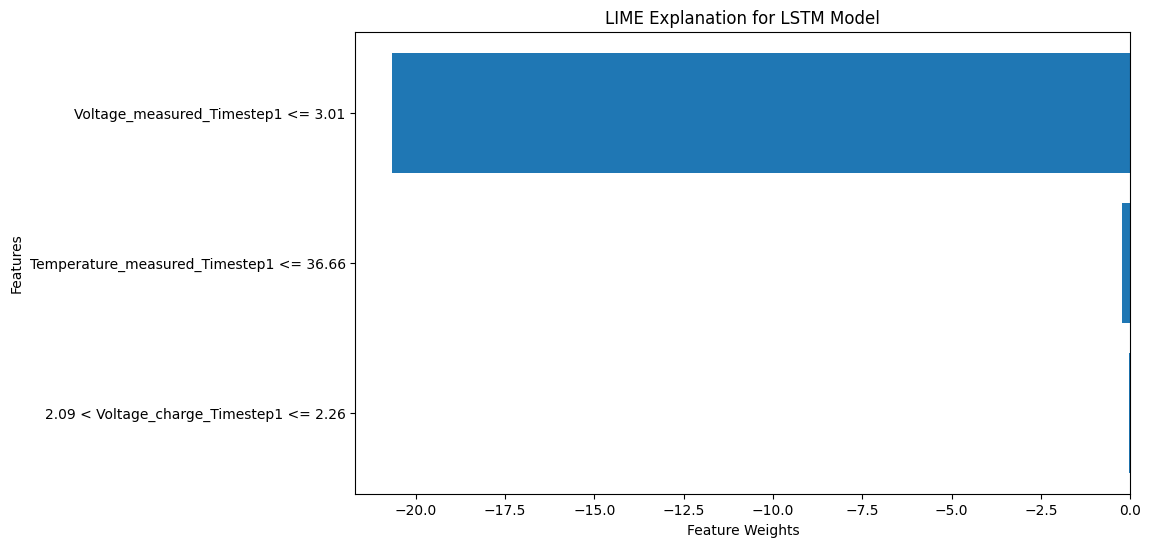

In [ ]:

# Get the feature names and their corresponding weights
feature_names, feature_weights = zip(*exp.as_list())

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_weights)
plt.xlabel('Feature Weights')
plt.ylabel('Features')
plt.title('LIME Explanation for LSTM Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

In [ ]:
# Get the feature names and their corresponding weights from the LIME explanation
feature_importances = np.array(exp.as_list())

# Calculate the sum of absolute feature importances
decision_impact = np.sum(np.abs(feature_importances[:, 1].astype(float)))
print("Sum of Absolute Feature Importances:", decision_impact)

Sum of Absolute Feature Importances: 20.92698143193576


In [ ]:
# Generate the LIME explanation for the RNN model
exp = explainer.explain_instance(
    data_row=instance_reshaped.flatten(),  # Flatten the instance for LIME
    predict_fn=rnn_predict_fn
)

# The R-squared value of the explanation can serve as a proxy for the confidence score
lime_r_squared = exp.score
print("LIME R-squared:", lime_r_squared)

157/157 [==============================] - 0s 2ms/step
LIME R-squared: 0.7660897202653499


In [ ]:
#Surogate model
# Predicting the training and testing set using the RNN model
rnn_predictions_train = model_rnn.predict(X_train_reshaped).flatten()  # Flatten to match the shape expected by LinearRegression
rnn_predictions_test = model_rnn.predict(X_test_reshaped).flatten()
# Generate expanded feature names for each timestep
expanded_feature_names = [f"{feature}_Timestep{timestep+1}" for timestep in range(num_time_steps) for feature in original_feature_names]

68/68 [==============================] - 0s 3ms/step


In [ ]:
# Create a linear regression model as the surrogate model
surrogate_model_rnn = LinearRegression()
# Train the surrogate model using the training data and the RNN's predictions
surrogate_model_rnn.fit(X_train_reshaped.reshape(-1, num_time_steps), rnn_predictions_train)

LinearRegression()

In [ ]:
# Get coefficients from the surrogate model
coefficients = surrogate_model_rnn.coef_

# Display the coefficients with expanded feature names
for feature, coef in zip(expanded_feature_names, coefficients):
    print(f"{feature}: {coef}")


Voltage_measured_Timestep1: 42.315659345814446
Voltage_charge_Timestep1: 1.4177271009141053
Temperature_measured_Timestep1: 0.005427512914347732


In [ ]:
# Make predictions with the surrogate model on the test set
surrogate_predictions_rnn = surrogate_model_rnn.predict(X_test_reshaped.reshape(-1, num_time_steps))

# Evaluate the surrogate model
mse_rnn = mean_squared_error(rnn_predictions_test, surrogate_predictions_rnn)
r2_rnn = r2_score(rnn_predictions_test, surrogate_predictions_rnn)

print(f"Mean Squared Error: {mse_rnn}")
print(f"R-squared: {r2_rnn}")  # This represents the confidence score for the surrogate model

Mean Squared Error: 0.0009225531316103547
R-squared: 0.9999907457618539


Coefficients shape: (3,)
Feature names shape: 3


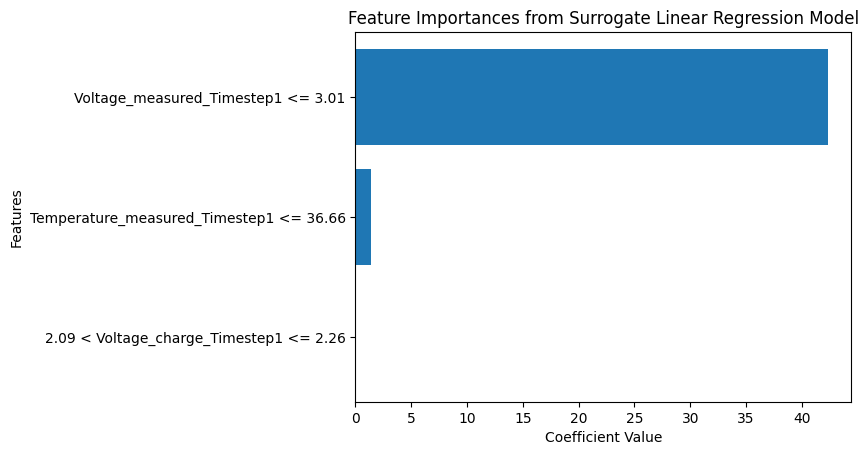

In [ ]:
# Reshape coefficients if necessary
coefficients = np.array(coefficients).flatten()

# Check the shapes
print("Coefficients shape:", coefficients.shape)
print("Feature names shape:", len(feature_names))

plt.barh(feature_names, coefficients)
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Importances from Surrogate Linear Regression Model')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Compute residuals
residuals_rnn = rnn_predictions_test - surrogate_predictions_rnn
mean_residual_rnn = np.mean(np.abs(residuals_rnn))
print("Mean Residual for RNN:", mean_residual_rnn)

# Decision Impact Ratio could be the sum of absolute coefficients
decision_impact_ratio_rnn = np.sum(np.abs(coefficients))
print("Decision Impact Ratio for RNN:", decision_impact_ratio_rnn)

Mean Residual for RNN: 0.020644040161622624
Decision Impact Ratio for RNN: 43.7388139596429
